All necessary packages installed and imported

In [4]:
pip install librosa soundfile pyaudio

  Using cached librosa-0.10.2.post1-py3-none-any.whl (260 kB)
  Using cached soundfile-0.12.1-py2.py3-none-win_amd64.whl (1.0 MB)
     ---------------------------------------- 64.6/64.6 kB 1.8 MB/s eta 0:00:00
     -------------------------------------- 167.3/167.3 kB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install "librosa==0.9.1"

     -------------------------------------- 213.1/213.1 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 3.1/3.1 MB 21.9 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.2.post1
    Uninstalling librosa-0.10.2.post1:
      Successfully uninstalled librosa-0.10.2.post1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

C:\Users\isisV\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

In [4]:
import librosa.display

Below are visual representations of the frequency spectrum of audio signals in documents 03-01-01-01-01-01-01.wav and 03-01-07-02-01-01-01.wav over time  
-The y-axis plots the frequency (in hertz) as the x-axis plots the time (in seconds) window duration of 3 seconds  
-The colors indicate the amplitude of each frequency using the Decibel scale. Brighter colors signify higher energy  

Text(0.5, 0, 'Window Duration (seconds)')

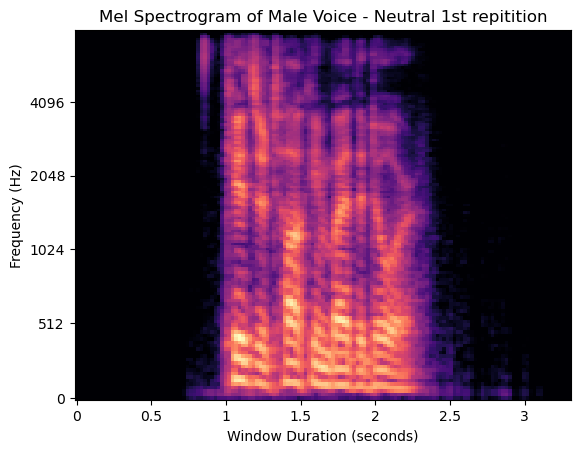

In [5]:
df, y=librosa.load('speech-emotion-recognition-ravdess-data\\Actor_01\\03-01-01-01-01-01-01.wav')

#computing a mel-scaled spectogram.
spectrogram=librosa.feature.melspectrogram(y=df, sr=y, n_mels=128,fmax=8000) #mapping the frequency bin of 128 mel bands is a common practice in audio signal processing
spectrogram=librosa.power_to_db(spectrogram) #convert spectogram to decibal
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time'); #display spectogram
plt.title('Mel Spectrogram of Male Voice - Neutral 1st repitition')
plt.ylabel("Frequency (Hz)")
plt.xlabel("Window Duration (seconds)")

Text(0.5, 0, 'Window Duration (seconds)')

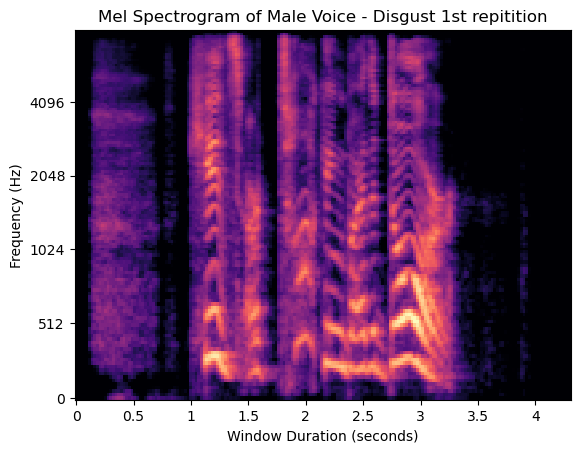

In [6]:
df2, y2=librosa.load('speech-emotion-recognition-ravdess-data\\Actor_01\\03-01-07-02-01-01-01.wav')

spectrogram=librosa.feature.melspectrogram(y=df2, sr=y2, n_mels=128,fmax=8000) #mapping the frequency bin of 128 mel bands is a common practice in audio signal processing
spectrogram=librosa.power_to_db(spectrogram) #convert spectogram to decibal
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time'); #display spectogram
plt.title('Mel Spectrogram of Male Voice - Disgust 1st repitition')
plt.ylabel("Frequency (Hz)")
plt.xlabel("Window Duration (seconds)")

Visualizing the waveform in speech is important for picking which features to extract by looking at the variations of amplitude it can show the emotional intensity and stress levels in speech. Higher amplitudes may indicate increased emotional stimulation. Same goes for the energy ditribution, it can signal emotional variation; when there are sudden energy bursts it may represent emotional outbursts. Waveforms also reveal temporal aspects of speech such as the speaking rate (pace of speech fast-slow), pauses, and rythmic patterns. This offers insight into the emotional state of the speaker.

Text(0.5, 3.722222222222216, 'Window Duration (seconds)')

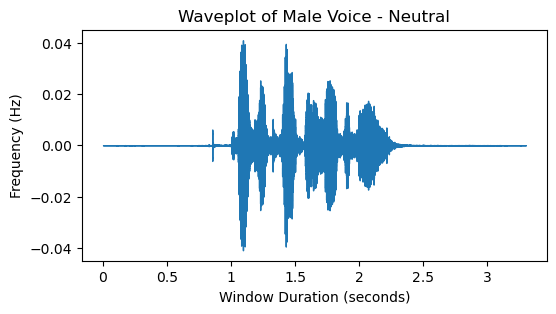

In [7]:
plt.figure(figsize=(6, 3))
librosa.display.waveshow(df, sr=y)
plt.title('Waveplot of Male Voice - Neutral')
plt.ylabel("Frequency (Hz)")
plt.xlabel("Window Duration (seconds)")

Text(0.5, 3.722222222222216, 'Window Duration (seconds)')

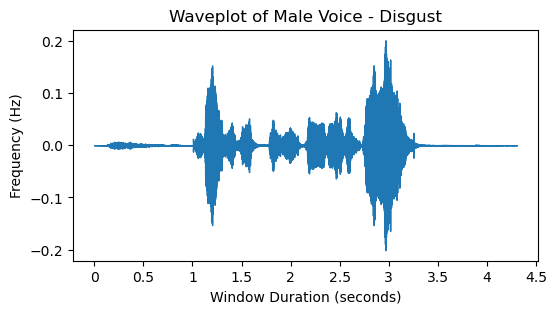

In [8]:
plt.figure(figsize=(6, 3))
librosa.display.waveshow(df2, sr=y2)
plt.title('Waveplot of Male Voice - Disgust')
plt.ylabel("Frequency (Hz)")
plt.xlabel("Window Duration (seconds)")

After reviewing the spectogram and waveplots the features to be extracted are the mfcc, chroma, and mel.

Feature extraction: Defining a method to extract the mfcc, chroma, and mel features from a sound file to use for modeling.  
-mfcc is the mel frequency cepstral coefficient, it represents the short-term power spectrum of a sound  
-chroma is the twelve different pitch classes  
-mel is the mel spectrogram frequency  
The Short-Time Fourier Transform is a fundamental concept in digital speech processing, it describes the frequency components in a signal averaged and characterizes signals with timevarying frequency components (Schafer, 2007). 

In [9]:
def extract_feature(file_name, mfcc, chroma, mel): #function definition
    with soundfile.SoundFile(file_name) as sound_file: #opening the sound file
        X = sound_file.read(dtype="float32") #reading the audio data
        sample_rate=sound_file.samplerate
        if chroma: #calculating the short time Fourier Transformation for chroma features upon request
            stft=np.abs(librosa.stft(X))
        result=np.array([]) #initializing the array into result
        if mfcc: #extracting the mfcc features upon request
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0) #calculating the mfcc
            result=np.hstack((result, mfccs)) #adding to the result array
        if chroma: #extracting chroma features upon request
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0) #calculating the chroma features
            result=np.hstack((result, chroma)) #adding to result array
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0) #calculating the mel spectogram
            result=np.hstack((result, mel)) #adding to result array
    return result

-A dictionary of the numbers and the emotions available in the RAVDESS dataset.  
-A list holding the emotions wanted: calm, happy, fearful, disgust.

In [10]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

A brief explanation of the data before moving on to loading each set.  
The files of the RAVDESS data have unique file names that consist of seven part numerical identifiers which define characteristics of the file:  
Modality, Vocal Channel, Emotion, Emotional intensity, Statement Type, Repitition, and the Actor.  
Filename Example: 03-01-01-01-01-01-11.wav  
Break down of the file name:  
03 - this file is audio-only  
01 - this file has speech, not song  
01 - the emotion is neutral  
01 - the emotion intensity is normal  
01 - the statement is "kids are talking by the door."  
01 - first repetition of the statement  
11 - the odd number indicates the actor is male. Even numbers are female.  

Speech conversion to text will not be needed for my project

In [11]:
def load_data(test_size=0.2): #load data default to 20% of the data
    x,y=[],[] #initialize two lists
    for file in glob.glob("speech-emotion-recognition-ravdess-data\\Actor_*\\*.wav"): #iterate through each file using glob for the .wav file types
        file_name=os.path.basename(file) #extracting the emotion label using the previous emotions dictionary mapping the numeric value
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions: #skip over files not containing the emotions from the observed_emotions list
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True) #calling the extract_features function
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9) #split data using random_state=9 to ensure reproducibility

In [12]:
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

C:\Users\isisV\AppData\Local\Temp\ipykernel_36364\4272804062.py:15: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0) #calculating the mel spectogram
C:\Users\isisV\AppData\Local\Temp\ipykernel_36364\4272804062.py:15: FutureWarning: Pass y=[0.0000000e+00 3.0517578e-05 3.0517578e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0) #calculating the mel spectogram
C:\Users\isisV\AppData\Local\Temp\ipykernel_36364\4272804062.py:15: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00 -3.0517578e-05 ... -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(l

In [13]:
print((x_train.shape[0], x_test.shape[0]))

(576, 192)


In [14]:
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


# Milestone 4

This is a Multi-layer Perceptron Classifier; it optimizes the log-loss function using LBFGS or stochastic gradient descent. Unlike SVM or Naive Bayes, the MLPClassifier has an internal neural network for the purpose of classification. This is a feedforward ANN model. Feedforward ANNs have a straightforward architecture that is easier to implement and train compared to others, since they process data in parallel it also leads to faster computation. 

In [15]:
#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

Fit and train the model

In [16]:
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

predict the values for the test set. This gives us y_pred (the predicted emotions for the features in the test set) then calculate the accuracy of the model.

In [18]:
y_pred=model.predict(x_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

In [19]:
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 63.54%


It's a pretty low accuracy score but at this point I am impressed the model even worked

Code Attribution:  
Title: Speech Emotion Recognition Project  
Author: Dipanjan Sarkar  
Date: 17/10/2024  
Modified By: Isis Lara  
Description:  

Title: Speech Emotion Recognition Project  
Author: Stefanie Molin  
Date: 17/10/2024  
Modified By: Isis Lara  
Description:  

Title: Speech Emotion Recognition Project  
Author: Armando Fandango  
Date: 17/10/2024  
Modified By: Isis Lara  
Description:  

Title: Speech Emotion Recognition Project  
Author: Librosa  
Date: 17/10/2024  
Modified By: Isis Lara  
Description:  

Title: Speech Emotion Recognition Project  
Author: Muriel Kosaka  
Date: 17/10/2024  
Modified By: Isis Lara  
Description:  

Title: Speech Emotion Recognition Project  
Author: Data Flair  
Date: 18/10/2024  
Modified By: Isis Lara  
Description:  

Title: Speech Emotion Recognition Project  
Author: m3hrdadfi  
Date: 20/10/2024  
Modified By: Isis Lara  
Description:  

Title: Speech Emotion Recognition Project  
Author:  
Date:  
Modified By: Isis Lara  
Description:  

Title: Speech Emotion Recognition Project  
Author:  
Date:  
Modified By: Isis Lara  
Description:  

Title: Speech Emotion Recognition Project  
Author:  
Date:  
Modified By: Isis Lara  
Description:  

Title: Speech Emotion Recognition Project  
Author:  
Date:  
Modified By: Isis Lara  
Description:  